https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews

# IMDB Review Sentiment Analysis

- Remove HTML elements
- Remove accented characters
    - What if the difference between unidecode and normalize?
- Expand contractions
- remove_non_alphanumeric_characters
- convert to lower case
- Remove stop words
    - splitting the text into words to compare with stopwords set sometimes fails because there is punctuation associated with the split word. eg: "I have it." -> `['I', 'have', 'it.']`, `it.` fails to match with `it` in the set.
- Tokenize words
    - How to remove commas, full stops and other punctuation after tokenizing?
- Stemm / Lemmatize words
- Make a pipeline to include all the preprocessing steps

Text preprocessing guides:
- https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72


Does removing all characters except a-z, A-z, 0-9 a good approach here?

Does restricting tokens by allowing only tokens between min and max frequency remove stop words and HTML elements?

How to handle new tokens in test set?

Next Steps:

I want to deploy this model in production
- How to get reviews from imdb.com? Is there an API? - not legal, however, you can scrap it.
- How to get reviews about movies from other sites? - TMDB - provides api - https://developers.themoviedb.org/3/movies/get-movie-reviews

https://api.themoviedb.org/3/movie/559/reviews?api_key=

Get the API key from https://www.themoviedb.org/settings/api

Create an UI that lists reviews from various sites and classifies with this model. Create a poll below the prediction to verify if its accurate or not. Use this information to train the model more.

Create dashboard to view if the accuracy and other metrics over time

In [1]:
%matplotlib inline   
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
LARGE_FIG_SIZE=(20, 15)

import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from  sklearn.preprocessing  import  OrdinalEncoder
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
from build_library.utils import normalize_corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/z00295n/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/z00295n/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
data  = pd.read_csv('./IMDB Dataset.csv')

In [5]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


### Convert sentiment to 0s and 1s using scikit learn's ordinal encoder

In [6]:
ord_encoder = OrdinalEncoder()
y = ord_encoder.fit_transform(data.sentiment.values.reshape(-1, 1))

In [7]:
ord_encoder.categories_

[array(['negative', 'positive'], dtype=object)]

### Split the data set into train and test set

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = list(split.split(data['review'], y))[0]

X_train = data['review'][train_index].values
y_train = y[train_index]

X_test = data['review'][test_index].values
y_test = y[test_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40000,) (40000, 1) (10000,) (10000, 1)


### Tokenize the words

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5, max_df=0.5, ngram_range=(1, 2))
# features = tfidf.fit_transform(data['review'].values[0:50])
# df=pd.DataFrame(
#     features.todense(),
#     columns=tfidf.get_feature_names()
# )

In [22]:
from sklearn.preprocessing import FunctionTransformer

normalize_text_transformer = FunctionTransformer(normalize_corpus)

In [21]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('normalize_text', normalize_text_transformer),
    ('tfidf', tfidf),
    ('lr', lr)
])

In [23]:
pipeline.fit(X_train, y_train.ravel())

Pipeline(steps=[('normalize_text',
                 FunctionTransformer(func=<function normalize_corpus at 0x7fe1eedb45e0>)),
                ('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=1, max_iter=500, random_state=42))])

In [24]:
y_train_predict = pipeline.predict(X_train)

In [25]:
# Training Error
from sklearn.metrics import accuracy_score
accuracy_score(y_train.ravel(), y_train_predict)

0.9465

In [26]:
y_pred = pipeline.predict(X_test)

scores

precision 0.8911045943304008
recall    0.9116
f1        0.9012357884330203
accuracy  0.9001


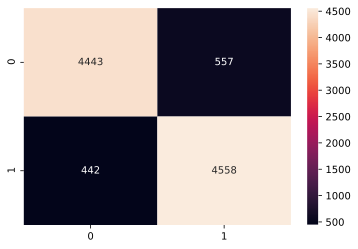

In [27]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score

def show_scores(y, y_pred):
    conf_mx = confusion_matrix(y, y_pred)
    print('scores\n')
    print('precision', precision_score(y, y_pred))
    print('recall   ', recall_score(y, y_pred))
    print('f1       ', f1_score(y, y_pred))
    print('accuracy ', np.sum(y == y_pred)/y.shape[0])


    sns.heatmap(conf_mx, annot=True, fmt='3.0f')

show_scores(y_test.ravel(), y_pred)

In [29]:
test_review = "N.T.R, Savitri, A.N.R in Mayabazar acted brilliantly. Dialogues look fresh!!!. Music and lyrics are super."
proba = pipeline.predict_proba(np.array([test_review]))
proba

array([[0.32065727, 0.67934273]])

In [30]:
import joblib
joblib.dump(pipeline, 'tf-idf-min-df-5linear-regression.pkl')

['tf-idf-min-df-5linear-regression.pkl']

In [28]:
len(tfidf.get_feature_names())

144810

In [23]:
import joblib
joblib.dump(tfidf, 'tf-idf.pkl')

['tf-idf.pkl']